# Perceptron

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,omegaconf --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
omegaconf: 2.3.0

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

### Perceptron Learning Algorithm

**Predict the output:**
$$z = w^T x + b$$
$$\hat{y} = \sigma(z)$$

**Update the weights and bias (Fit):**
$$\Delta{w_{j}} = \eta (y - \hat{y}) x_{j}$$
$$\Delta{b} = \eta (y - \hat{y})$$

$$w_{j} = w_{j} + \Delta{w_{j}}$$
$$b = b + \Delta{b}$$


<br>

Where:

$\Delta{w_{j}}$ is the change in weight, $\Delta{b}$ is the change in bias, $\eta$ is the learning rate.

In [3]:
class Perceptron:
    def __init__(self, eta: float, epochs: int, seed: int = 42) -> None:
        assert 0 <= eta <= 1, "eta must be between 0 and 1"
        self.eta = eta
        assert epochs >= 1, "epochs must be greater than 0"
        self.epochs = epochs
        assert seed >= 0, "seed must be greater than or equal to 0"
        self.seed = seed

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}(eta={self.eta}, "
            f"epochs={self.epochs}, seed={self.seed})"
        )

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        rng = np.random.default_rng(self.seed)
        # Mean of 0 and standard deviation of 0.01
        self.w_: np.ndarray = rng.normal(loc=0, scale=0.01, size=X.shape[1])
        self.b_: np.ndarray = np.float_(0)
        self.errors_: list[int] = []

        for _ in range(self.epochs):
            errors: int = 0
            for x, target in zip(X, y):
                # Calculate the update
                update: np.ndarray = self.eta * (target - self.predict(x))
                # Update the weights and bias
                self.w_ += update * x
                self.b_ += update
                # Count the number of errors
                errors += int(update != 0.0)
            # Store the errors after each epoch
            self.errors_.append(errors)
        return self

    def _predict(self, X: np.ndarray) -> np.ndarray:
        z: np.ndarray = X.dot(self.w_) + self.b_
        return z

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.where(self._predict(X) >= 0.0, 1, 0)

In [4]:
ppn: Perceptron = Perceptron(eta=0.1, epochs=10, seed=2)

X: np.ndarray = np.array([[1, 2, 3, 2.5, -5], [2.0, 5.0, -5.0, -2.0, 3.5]]).reshape(
    -1, 2
)
y = np.array([1, 1, 0, 1, 0])

ppn.fit(X, y)

Perceptron(eta=0.1, epochs=10, seed=2)

In [5]:
ppn.predict(X)

array([1, 1, 0, 1, 0])

In [6]:
# Raw values
ppn._predict(X), X.shape

(array([ 0.19143556,  1.24260289, -3.41990764,  4.73559009, -2.07207726]),
 (5, 2))

In [7]:
ppn.errors_

[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]

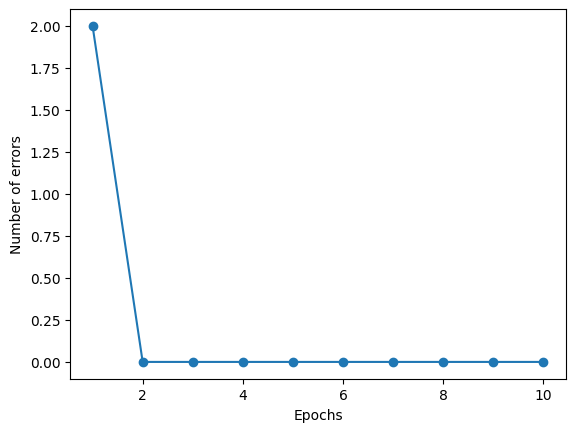

In [8]:
# Visualize the errors
ppn: Perceptron = Perceptron(eta=0.1, epochs=10, seed=2)
ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Number of errors")
plt.show()

In [9]:
fp: str = "./data/iris_data.csv"
df: pl.DataFrame = pl.read_csv(fp)
df = df.filter(pl.col("class").ne("None"))

df.head()

sepal_length,sepal_width,petal_length,petal_width,class
f64,f64,f64,f64,str
5.1,3.5,1.4,0.2,"""Iris-setosa"""
4.9,3.0,1.4,0.2,"""Iris-setosa"""
4.7,3.2,1.3,0.2,"""Iris-setosa"""
4.6,3.1,1.5,0.2,"""Iris-setosa"""
5.0,3.6,1.4,0.2,"""Iris-setosa"""


In [10]:
df.select("class").to_series().value_counts().to_pandas()

,class,count
0,Iris-versicolor,50
1,Iris-virginica,50
2,Iris-setosa,50


In [11]:
X: np.ndarray = df.select(
    ["sepal_length", "sepal_width", "petal_length", "petal_width"]
).to_numpy()

y: np.ndarray = (
    df.with_columns(
        label=pl.when(pl.col("class").eq("Iris-setosa"))
        .then(pl.lit(0))
        .otherwise(pl.lit(1))
    )
    .select("label")
    .to_numpy()
    .squeeze()
)

X.shape, y.shape

((150, 4), (150,))

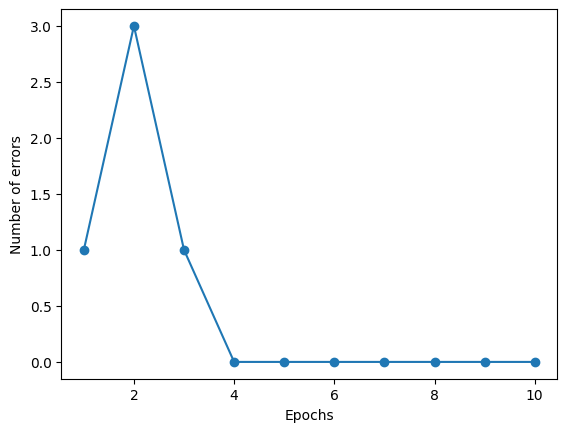

In [12]:
# Visualize the errors
ppn: Perceptron = Perceptron(eta=0.1, epochs=10, seed=2)
ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Number of errors")
plt.show()